In [10]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets

In [11]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("PIL version : ", PIL.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: win32
Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
---
PIL version :  10.2.0
torch version :  2.2.2+cpu
torchvision version :  0.17.2+cpu


In [12]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [13]:
mtcnn0 = MTCNN(image_size=240,device=device, keep_all=False, min_face_size=40)
print(mtcnn0)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

In [14]:
resnet = InceptionResnetV1(pretrained="vggface2").eval()

In [15]:

print(resnet)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [25]:
data_dir = Path("Project4")
sub_dir = "data"
sub2_dir = "images"


images_folder = data_dir / sub_dir / sub2_dir
print(f"Path to images: {images_folder}")

# project_dir = Path("project4")
# data_dir = "data"
# video_dir = project_dir / data_dir

# print(video_dir)

Path to images: Project4\data\images


In [26]:
dataset = datasets.ImageFolder(images_folder)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 10
    Root location: Project4\data\images


In [27]:
for subdirectory in images_folder.iterdir():
    print(subdirectory)

Project4\data\images\mary_kom
Project4\data\images\ranveer


In [28]:
dataset.class_to_idx

{'mary_kom': 0, 'ranveer': 1}

In [29]:

idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

print(idx_to_class)

{0: 'mary_kom', 1: 'ranveer'}


In [30]:
def collate_fn(x):
    return x[0]

In [31]:

loader = DataLoader(dataset, collate_fn=collate_fn)

print(loader.dataset)

Dataset ImageFolder
    Number of datapoints: 10
    Root location: Project4\data\images


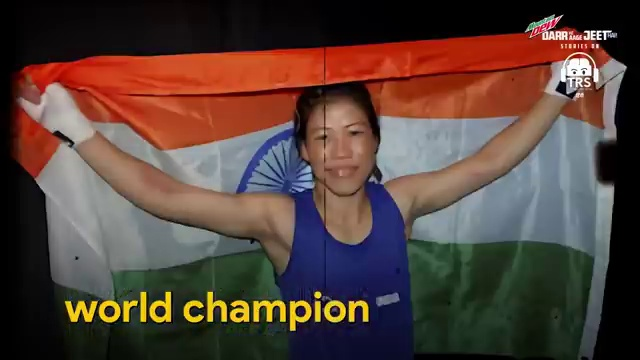

In [32]:
img, _ = iter(loader).__next__()
img

In [33]:
face, prob = mtcnn0(img, return_prob=True)

print(type(face))
print(f"Probability of detected face: {prob}")

<class 'torch.Tensor'>
Probability of detected face: 0.9999592304229736


In [34]:
try:
    resnet(face)
except ValueError as e:
    print(e)

expected 4D input (got 3D input)


In [35]:
print(face.shape)

torch.Size([3, 240, 240])


In [36]:
face_4d = face.unsqueeze(0) # Adding a new dimension at position 0

print(face_4d.shape) 

torch.Size([1, 3, 240, 240])


In [37]:

embedding = resnet(face_4d)

print(f"Shape of face embedding: {embedding.shape}")

Shape of face embedding: torch.Size([1, 512])


In [38]:

# Dictionary that maps name to list of their embeddings
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True)
    if face is not None and prob >= 0.9:
        emb = resnet(face.unsqueeze(0))
        name_to_embeddings[idx_to_class[idx]].append(emb)

In [39]:
print(name_to_embeddings.keys())
print(type(name_to_embeddings["mary_kom"]))

dict_keys(['mary_kom', 'ranveer'])
<class 'list'>


In [40]:

embeddings_mary = torch.stack(name_to_embeddings["mary_kom"])
embeddings_ranveer = torch.stack(name_to_embeddings["ranveer"])

embeddings_mary_shape = embeddings_mary.shape
embeddings_ranveer_shape = embeddings_ranveer.shape

print(f"Shape of stack of embeddings for Mary: {embeddings_mary_shape}")
print(f"Shape of stack of embeddings for Ranveer: {embeddings_ranveer_shape}")

Shape of stack of embeddings for Mary: torch.Size([5, 1, 512])
Shape of stack of embeddings for Ranveer: torch.Size([4, 1, 512])


In [41]:
avg_embedding_mary = torch.mean(embeddings_mary, dim=0)
avg_embedding_ranveer = torch.mean(embeddings_ranveer, dim=0)

print(f"Shape of avg_embedding: {avg_embedding_mary.shape}")
print(f"Shape of avg_embedding: {avg_embedding_ranveer.shape}")

Shape of avg_embedding: torch.Size([1, 512])
Shape of avg_embedding: torch.Size([1, 512])


In [42]:

embeddings_to_save = [
    (avg_embedding_mary, "mary_kom"),
    (avg_embedding_ranveer, "ranveer"), 
]


torch.save(embeddings_to_save, "embeddings.pt")

In [43]:
embedding_data = torch.load("embeddings.pt")

names = [name for _, name in embedding_data]
print(f"Loaded the embedding for: {names}")

Loaded the embedding for: ['mary_kom', 'ranveer']


In [47]:
from pathlib import Path
test_img_path = Path("Project2", "data", "extracted_frames", "frame_100.jpg")
print(test_img_path.resolve())  # shows full path


D:\Projects\Celebrity Sightings in India\Project2\data\extracted_frames\frame_100.jpg


In [51]:
import os
print(os.getcwd())


d:\Projects\Celebrity Sightings in India


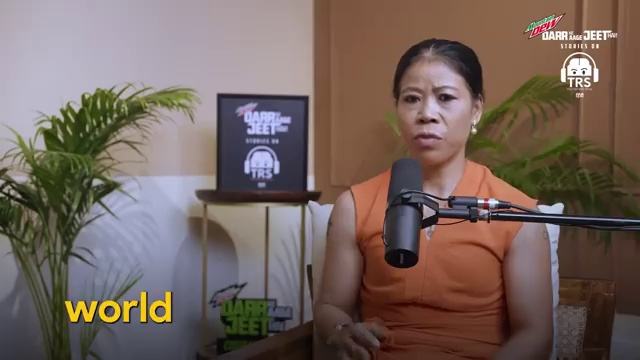

In [54]:
test_img_path = Path("Project4", "data", "extracted_frames", "frame_100.jpg")

test_img = Image.open(test_img_path)
test_img

In [55]:
mtcnn = MTCNN(image_size=240, keep_all=True, min_face_size=40)
print(f"MTCNN image size: {mtcnn.image_size}")
print(f"MTCNN keeping all faces: {mtcnn.keep_all}")

MTCNN image size: 240
MTCNN keeping all faces: True


In [56]:
img_cropped_list, prob_list = mtcnn(test_img, return_prob=True)

print(f"Number of detected faces: {len(prob_list)}")
print(f"Probability of detected face: {prob_list[0]}")

Number of detected faces: 1
Probability of detected face: 0.9999531507492065


In [57]:
for i, prob in enumerate(prob_list):
    if prob > 0.90:
        emb = resnet(img_cropped_list[i].unsqueeze(0))

In [58]:
distances = {}

for known_emb, name in embedding_data:
    dist = torch.dist(emb, known_emb)
    distances[name] = dist

closest, min_dist = min(distances.items(), key=lambda x: x[1])
print(f"Closest match: {closest}")
print(f"Calculated distance: {min_dist :.2f}")

Closest match: mary_kom
Calculated distance: 0.58


In [59]:
boxes, _ = mtcnn.detect(test_img)
print(f"Shape of boxes tensor: {boxes.shape}")

Shape of boxes tensor: (1, 4)


In [60]:
threshold = 0.8

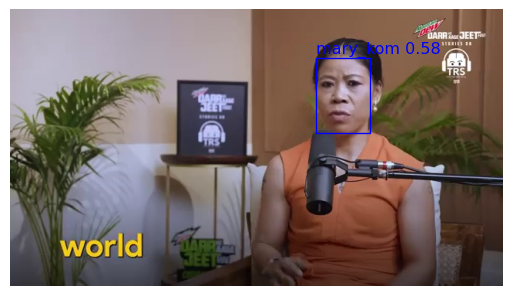

In [61]:
# This sets the image size and draws the original image
width, height = test_img.size
dpi = 96
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
axis = fig.subplots()
axis.imshow(test_img)
plt.axis("off")

for box in boxes:
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    axis.add_patch(rect)

    closest, min_dist = min(distances.items(), key=lambda x: x[1])

    # Drawing the box with recognition results

    if min_dist < threshold:
        name = closest
        color = "blue"
    else:
        name = "Unrecognized"
        color = "red"

    plt.text(
        box[0],
        box[1],
        f"{name} {min_dist:.2f}",
        fontsize=12,
        color=color,
        ha="left",
        va="bottom",
    )

plt.axis("off")
plt.show()

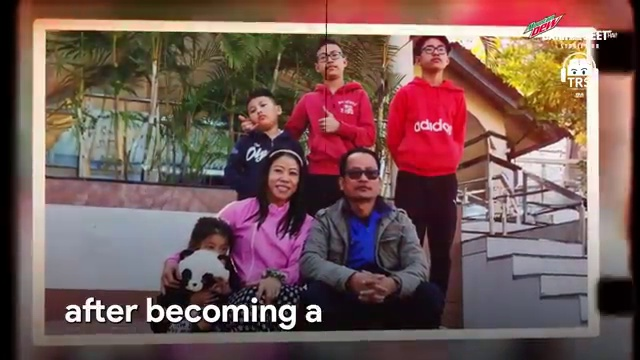

In [65]:
img_multiple_people_path = Path("Project4","data", "extracted_frames", "frame_210.jpg")
img_multiple_people = Image.open(img_multiple_people_path)

img_multiple_people

In [66]:
def recognize_faces(img_path, embedding_data, mtcnn, resnet, threshold=0.7):
    # Generating the bounding boxes, faces tensors, and probabilities
    image = Image.open(img_path)
    boxes, probs = mtcnn.detect(image)
    cropped_images = mtcnn(image)

    if boxes is None:
        return

    # This sets the image size and draws the original image
    width, height = image.size
    dpi = 96
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    axis = fig.subplots()
    axis.imshow(image)
    plt.axis("off")

    # Iterating over each face and comparing it against the pre-calculated embeddings
    # from our "database"
    for box, prob, face in zip(boxes, probs, cropped_images):
        if prob < 0.90:
            continue

        # Draw bounding boxes for all detected faces
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            color="blue",
        )
        axis.add_patch(rect)

        # Find the closest face from our database of faces
        emb = resnet(face.unsqueeze(0))
        distances = {}
        for known_emb, name in embedding_data:
            dist = torch.dist(emb, known_emb).item()
            distances[name] = dist

        closest, min_dist = min(distances.items(), key=lambda x: x[1])

        # Drawing the box with recognition results
        name = closest if min_dist < threshold else "Unrecognized"
        color = "red" if name == "Unrecognized" else "blue"
        label = f"{name} {min_dist:.2f}"

        axis.text(box[0], box[1], label, fontsize=8, color=color)

    plt.axis("off")
    plt.show()

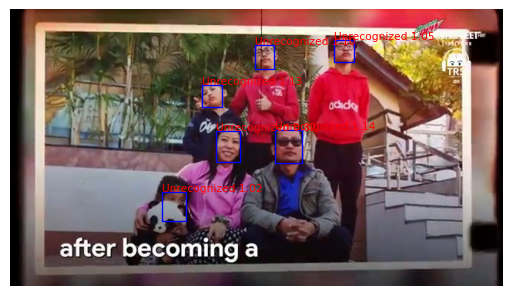

In [67]:
recognize_faces(img_multiple_people_path, embedding_data, mtcnn, resnet)

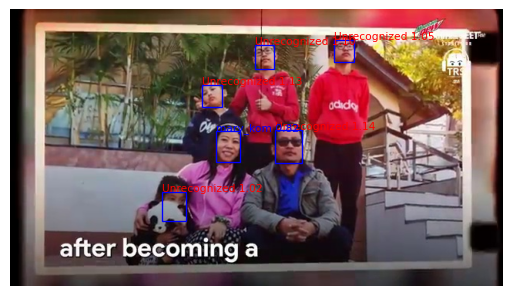

In [68]:
recognize_faces(img_multiple_people_path, embedding_data, mtcnn, resnet, threshold=0.90)